# NASA Min-MeteorologicalYear 

Calculates two-week minimum DNI to create a Minimum TMY 

Uses NASA data files for ~20 years

In [1]:
import pvlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
testfolder = r'../DATA/WeatherFilesNASA'

In [3]:
filelist = sorted(os.listdir(testfolder))

In [4]:
tmydata = pd.DataFrame()

for ii in range (0, len(filelist)):

    SAMfile = os.path.join(testfolder, filelist[ii])
    
    with open(SAMfile) as myfile:
        head = next(myfile)#
        meta = next(myfile)

    meta2=meta.split(',')
    meta2[-1] = meta2[-1][:-1] # Remove the carryover sig

    head2 = head.split(',')
    head2[-1] = head2[-1][:-1] 

    res = {head2[i]: meta2[i] for i in range(len(head2))}


    data = pd.read_csv(SAMfile, skiprows=2)

    metadata = {}
    metadata['TZ'] = float(res['Time Zone'])
    metadata['latitude'] = float(res['Latitude'])
    metadata['longitude'] = float(res['Longitude'])
    metadata['altitude'] = float(res['Elevation'])
    metadata['city'] = res['Source']


    if 'Minute' in data.columns:
        dtidx = pd.to_datetime(
            data[['year', 'month', 'day', 'hour', 'minute']])
    else: 
        dtidx = pd.to_datetime(
            data[['year', 'month', 'day', 'hour']])
    # in USA all timezones are integers
    tz = 'Etc/GMT%+d' % -metadata['TZ']
    data.index = pd.DatetimeIndex(dtidx).tz_localize(tz)

    #data.rename(columns={'Tdry':'DryBulb'}, inplace=True) 
    tmydata = pd.concat([tmydata, data], sort=False)


In [5]:
print(len(data))    # 1 year data
print(len(tmydata)) # All years data

8760
184080


In [6]:
smalltmy = tmydata[~tmydata['dni'].isna()]
smalltmy = smalltmy.drop(columns='snow') # Droping snow column, it's all Nans

In [7]:
#hourly min Doesn't yield good results as it is very cloudy DNI ALL year
'''
mindni = pd.DataFrame()

for ii in range(0,len(data)):
    foo = smalltmy[(smalltmy['month']==data['month'][ii]) & (smalltmy['day']==data['day'][ii]) & (smalltmy['hour']==data['hour'][ii])]
    asdf = foo.loc[foo['dni'].idxmin()]
    asdf = asdf.to_frame().T
    mindni = pd.concat([mindni, asdf])
'''

"\nmindni = pd.DataFrame()\n\nfor ii in range(0,len(data)):\n    foo = smalltmy[(smalltmy['month']==data['month'][ii]) & (smalltmy['day']==data['day'][ii]) & (smalltmy['hour']==data['hour'][ii])]\n    asdf = foo.loc[foo['dni'].idxmin()]\n    asdf = asdf.to_frame().T\n    mindni = pd.concat([mindni, asdf])\n"

In [8]:
data['month'] = data['month'].astype('int')
data['day'] = data['day'].astype('int')
data['hour'] = data['hour'].astype('int')
data['week'] = data.index.isocalendar().week
tmydata['DOY'] = tmydata.index.dayofyear

In [9]:
year_foo = pd.DataFrame()
frames = []
# Every 14 days 2 weeks
for ii in range(0,int(len(data)/24/14)):
    foo = tmydata[(tmydata['DOY']>=(ii*14+1))&(tmydata['DOY'] <=(ii*14+14))]
    
    ghi_min = 1000000
    for yyear in foo.year.unique():
        foo2 = foo[foo['year'] == yyear]
        ghi_sum = foo2['dni'].sum()
        if ghi_min > ghi_sum:
            ghi_min = ghi_sum
            temp_foo = foo[foo['year'] == yyear]
    
    frames.append(temp_foo)


foo = tmydata[(tmydata['DOY']>(ii*14+14))&(tmydata['DOY'] <=(380))] # last couple days that don't make a week
    
ghi_min = 1000000
for yyear in foo.year.unique():
    foo2 = foo[foo['year'] == yyear]
    ghi_sum = foo2['dni'].sum()
    if ghi_min > ghi_sum:
        ghi_min = ghi_sum
        temp_foo = foo[foo['year'] == yyear]
    
frames.append(temp_foo)

    
minyear = pd.concat(frames)

In [10]:
minyear

,year,month,day,hour,ghi,dni,dhi,tdry,twet,Tdew,wspd,wdir,rh,pres,snow,albedo,aod,DOY
2010-01-01 00:00:00+14:00,2010,1,1,0,475.305,1052.141,72.742,-29.791,-30.127,-30.470,2.468,51.425,93.062,690.853,NaN,0.750,0.0,1
2010-01-01 01:00:00+14:00,2010,1,1,1,472.062,1033.125,77.539,-29.791,-30.142,-30.502,2.538,47.370,92.875,690.932,NaN,0.742,0.0,1
2010-01-01 02:00:00+14:00,2010,1,1,2,471.375,1012.969,84.617,-29.767,-30.119,-30.478,2.659,42.976,92.812,691.036,NaN,0.758,0.0,1
2010-01-01 03:00:00+14:00,2010,1,1,3,468.469,963.477,100.016,-29.720,-30.072,-30.423,2.804,39.233,93.000,691.206,NaN,0.750,0.0,1
2010-01-01 04:00:00+14:00,2010,1,1,4,466.336,913.086,116.016,-29.666,-30.002,-30.337,2.903,36.685,93.188,691.377,NaN,0.742,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 19:00:00+14:00,2002,12,31,19,349.992,125.977,300.383,-26.806,-27.650,-28.494,0.896,312.879,84.125,694.545,NaN,0.773,0.0,365
2002-12-31 20:00:00+14:00,2002,12,31,20,347.734,119.156,301.133,-26.994,-27.767,-28.541,0.880,305.242,85.375,694.473,NaN,0.773,0.0,365
2002-12-31 21:00:00+14:00,2002,12,31,21,344.125,119.867,297.547,-27.205,-27.884,-28.556,0.888,293.860,87.000,694.361,NaN,0.773,0.0,365
2002-12-31 22:00:00+14:00,2002,12,31,22,340.844,120.438,294.320,-27.384,-27.955,-28.525,0.929,280.176,88.938,694.302,NaN,0.773,0.0,365


In [11]:
meta2

['NASA/POWER', '-90.0', '0.0', '14.0', '2811.04']

In [12]:
metdata = {'latitude':  '-90.0',  # From the NOAA metdata
           'longitude':-0.0,
           'source':'NASA',
           'elevation': 2811.04,
            'tz':14}

In [13]:
# Rename for SAM
minyear.rename(columns={"wspd": 'wind_speed'}, inplace=True)
minyear.rename(columns={"tdry": 'temp_air'}, inplace=True)

In [14]:
minyear['year'] = 2021  # Not really useful, as the weather file saves based on the index year
minyear['minute'] = 0  # Not really useful, as the weather file saves based on the index year

In [15]:
minyear

,year,month,day,hour,ghi,dni,dhi,temp_air,twet,Tdew,wind_speed,wdir,rh,pres,snow,albedo,aod,DOY,minute
2010-01-01 00:00:00+14:00,2021,1,1,0,475.305,1052.141,72.742,-29.791,-30.127,-30.470,2.468,51.425,93.062,690.853,NaN,0.750,0.0,1,0
2010-01-01 01:00:00+14:00,2021,1,1,1,472.062,1033.125,77.539,-29.791,-30.142,-30.502,2.538,47.370,92.875,690.932,NaN,0.742,0.0,1,0
2010-01-01 02:00:00+14:00,2021,1,1,2,471.375,1012.969,84.617,-29.767,-30.119,-30.478,2.659,42.976,92.812,691.036,NaN,0.758,0.0,1,0
2010-01-01 03:00:00+14:00,2021,1,1,3,468.469,963.477,100.016,-29.720,-30.072,-30.423,2.804,39.233,93.000,691.206,NaN,0.750,0.0,1,0
2010-01-01 04:00:00+14:00,2021,1,1,4,466.336,913.086,116.016,-29.666,-30.002,-30.337,2.903,36.685,93.188,691.377,NaN,0.742,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 19:00:00+14:00,2021,12,31,19,349.992,125.977,300.383,-26.806,-27.650,-28.494,0.896,312.879,84.125,694.545,NaN,0.773,0.0,365,0
2002-12-31 20:00:00+14:00,2021,12,31,20,347.734,119.156,301.133,-26.994,-27.767,-28.541,0.880,305.242,85.375,694.473,NaN,0.773,0.0,365,0
2002-12-31 21:00:00+14:00,2021,12,31,21,344.125,119.867,297.547,-27.205,-27.884,-28.556,0.888,293.860,87.000,694.361,NaN,0.773,0.0,365,0
2002-12-31 22:00:00+14:00,2021,12,31,22,340.844,120.438,294.320,-27.384,-27.955,-28.525,0.929,280.176,88.938,694.302,NaN,0.773,0.0,365,0


In [16]:
pvlib.iotools.write_sam(minyear, metdata, savefile=r'SAM_MinTMY_DNI_WeatherFile_Realyear.csv', standardSAM=False)

In [17]:
# Replacing with 2021 so it's easier to plot/analyse
minyear['datetime'] = pd.to_datetime(minyear[['year', 'month', 'day', 'hour', 'minute']], format="%Y-%m-%d_%H%M").dt.tz_localize(tz=tz)


In [18]:
minyear.set_index('datetime', inplace=True)

(0.0, 1200.0)

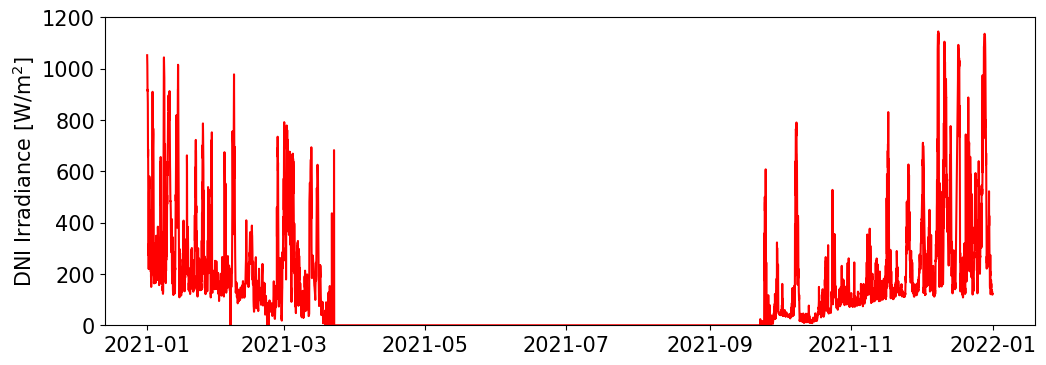

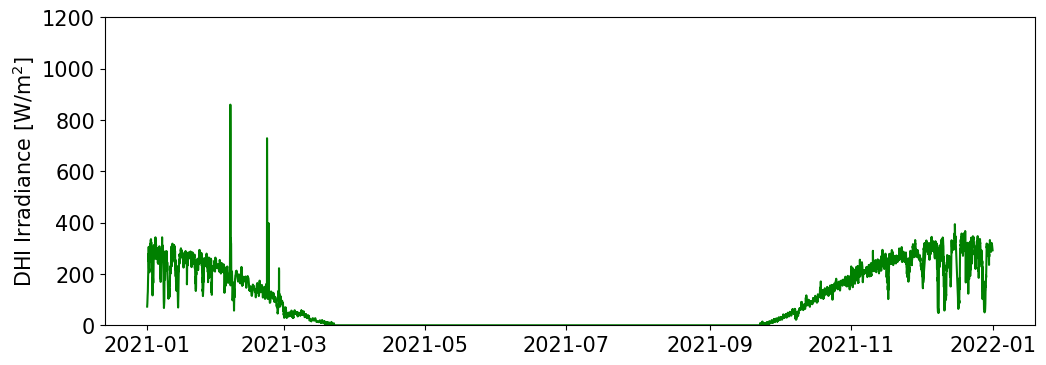

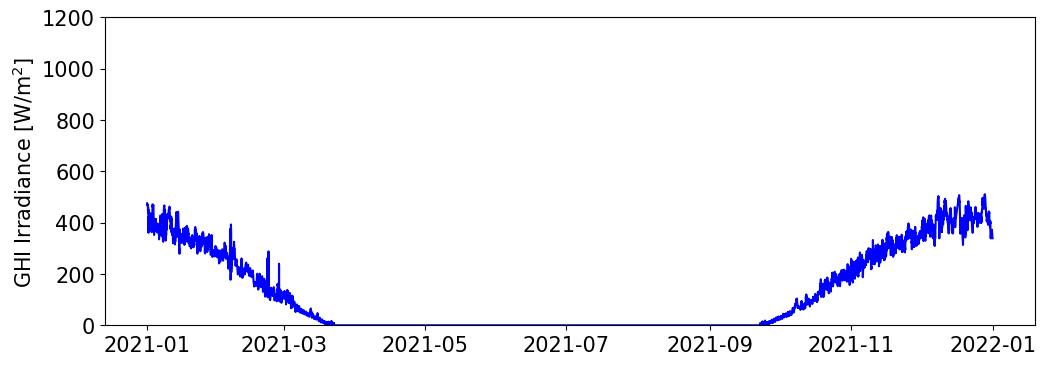

In [19]:
data = minyear.copy()

plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(data['dni'], 'r')
plt.ylabel('DNI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
plt.figure()
plt.plot(data['dhi'], 'g')
plt.ylabel('DHI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
plt.figure()
plt.plot(data['ghi'], 'b')
plt.ylabel('GHI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
